# Testing Module

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import cProfile, pstats
import gc
import pickle

In [4]:
# import QLearn
from QLearn.q_agents import HeuristicAgent, QAgent, ReplayMemory
from QLearn.environment import Environment
from QLearn.run_agent import do_run, heuristic_demo, agent_demo, Reward

In [5]:
def t_qnet(agent,env,n_step):
    pr = cProfile.Profile()
    s = env.reset()
    pr.enable()
    for _ in range(n_step):
        a = agent.action_select(s)
        s, r, done, _ = env.step(a)
        agent.update(s,r,done)
    pr.disable()
    sortby = 'cumulative'
    ps = pstats.Stats(pr).sort_stats(sortby)
    return ps

In [6]:
def heuristic(s):
    # Heuristic for:
    # 1. Testing. 
    # 2. Demonstration rollout.
    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center (s[0] is horizontal coordinate, s[2] hor speed)
    if angle_targ >  0.4: angle_targ =  0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proporional to horizontal offset

    # PID controller: s[4] angle, s[5] angularSpeed
    angle_todo = (angle_targ - s[4])*0.5 - (s[5])*1.0
    #print("angle_targ=%0.2f, angle_todo=%0.2f" % (angle_targ, angle_todo))

    # PID controller: s[1] vertical coordinate s[3] vertical speed
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5
    #print("hover_targ=%0.2f, hover_todo=%0.2f" % (hover_targ, hover_todo))

    if s[6] or s[7]: # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    a = 0
    if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
    elif angle_todo < -0.05: a = 3
    elif angle_todo > +0.05: a = 1
    return a

def random_agent(s):
    return np.random.randint(4)

## Run

In [26]:
del agent

In [9]:
env = Environment("gym_MarsLander:MarsLander-v0")
kwargs = {'memory_size':50000,'minibatch_size':20,'alpha':0.005}
agent = HeuristicAgent(env,heuristic,net_type='MLPQNet',hidden_layers=[80, 40],clip_norm=1.0,eps0=0.7, n_eps=1500, n_xi=1000, **kwargs)
print(agent.nn.k)

20


In [ ]:
env = Environment("gym_MarsLander:MarsLander-v0")
gc.enable()
agent = HeuristicAgent(env,heuristic,net_type='MLPQNet',hidden_layers=[80, 40],memory_size=50000,minibatch_size=20,alpha=0.005,clip_norm=1.0,eps0=0.7, n_eps=1500, n_xi=1000)
R, agent, _ = do_run(agent, env, 2000, save_name = 'data_test.pkl')
gc.disable()

In [ ]:
R_dem = agent_demo(show_agent,env,5)

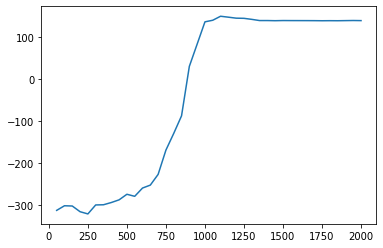

In [9]:
x,R = R.smooth(n_avg=50)
plt.plot(x,R)
plt.show()

In [11]:
env.gym_env.close()

## Compare

In [ ]:
env = Environment("gym_MarsLander:MarsLander-v0")
R_heur = heuristic_demo(heuristic, env, 10)

In [ ]:
print(R_heur)

In [ ]:
env = Environment("gym_MarsLander:MarsLander-v0")
R_rand = heuristic_demo(random_agent, env, 100)
print(R_rand)
print(np.mean(R_rand))

## Misc Testing

In [ ]:
env = Environment("gym_MarsLander:MarsLander-v0")
agent = QAgent(env,net_type='MLPQNet',hidden_layers=[120, 60],memory_size=100000,minibatch_size=20,alpha=0.005,clip_norm=1.0,eps0=0.7, n_eps=1500)
_, agent, env = do_run(agent,env,1)
ps_ep1 = t_qnet(agent,env,100)
ps_ep1.print_stats(20)

In [ ]:
env = Environment("gym_MarsLander:MarsLander-v0")
agent = QAgent(env,net_type='MLPQNet',hidden_layers=[120, 60],memory_size=100000,minibatch_size=20,alpha=0.005,clip_norm=1.0,eps0=0.7, n_eps=1500)
_, agent, env = do_run(agent,env,100)
ps_ep100 = t_qnet(agent,env,100)
ps_ep100.print_stats(20)

## Loading Data

In [27]:
fname = 'data_test_28_2.pkl'
data = pickle.load(open(fname,'rb'))

-282.87024401123404


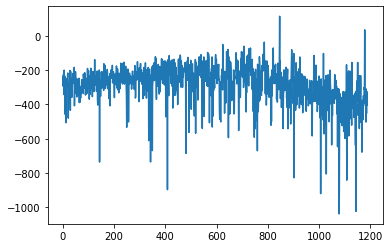

In [28]:
print(np.mean(data['R']))
plt.plot(data['R'])
plt.show()

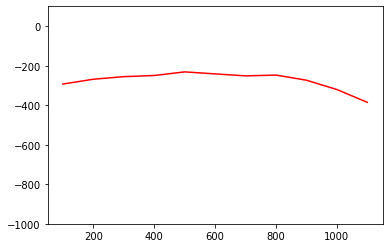

In [29]:
x,R_ep = data['R'].smooth()
plt.plot(x,R_ep,'r')
plt.ylim([-1000, 100])
plt.show()

In [ ]:
env = Environment("gym_MarsLander:MarsLander-v0")
agent = QAgent(env,net_type='MLPQNet',hidden_layers=[80, 40],memory_size=50000,minibatch_size=20,alpha=0.005,clip_norm=1.0,eps0=0.0, n_eps=1000)
agent.nn.assign_params(data['params'])
R_sim = agent_demo(agent, env, 10)

In [31]:
env.gym_env.close()

In [ ]:
np.mean(data['R'][:20])

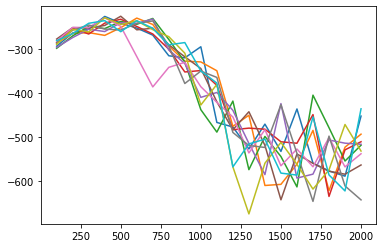

In [8]:
for run_no in range(10):
    fname = 'data{}_19_2.pkl'.format(run_no)
    data = pickle.load(open(fname,'rb'))
    x,R_ep = data['R'].smooth(100)
    plt.plot(x,R_ep)
# plt.ylim([-500, 100])
plt.show()